Nome: Felipe Faustino Brito

Matrícula: 2021007366

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal
import control as ctl
import control.matlab as cnt
import scipy.io.wavfile as wavfile
pi = np.pi

### 1) Gerar o sinal no Python com duração de 2s. Este sinal será usado para testar o filtro a ser desenvolvido.

In [3]:
def get_signal(components: dict[float, float], frequency: float, time=None) -> tuple[np.ndarray, np.ndarray]:
    """
        Gera um sinal composto por várias componentes senoidais.
        
        Params:
            components (dict[float, float]): Um dicionário onde as chaves são as frequências (em Hz) e os valores são as amplitudes das componentes senoidais.
            frequency (float): A frequência de amostragem do sinal (em Hz).
            time (np.ndarray, opcional): Um array de tempos. Se não for fornecido, será gerado automaticamente com base na frequência de amostragem.
        Returns:
            tuple[np.ndarray, np.ndarray]: Uma tupla contendo o sinal gerado e o array de tempos.
    """

    if time is None:
        time = np.arange(0, 2, 1/frequency)
    signal_data = np.zeros_like(time)
    for freq, amp in components.items():
        signal_data += amp * np.sin(2 * np.pi * freq * time)

    return signal_data, time

In [4]:
def plot_signal(signal: np.ndarray, time: np.ndarray, frequency: float, limite=800):
    """
        Plota um sinal no domínio do tempo e sua resposta em frequência.
        
        Params:
            signal (np.ndarray): O sinal a ser plotado.
            time (np.ndarray): O array de tempos correspondente ao sinal.
            frequency (float): A frequência de amostragem do sinal (em Hz).
            limite (float, opcional): O limite superior do eixo x da resposta em frequência.
    """
    # Plotar o sinal no domínio do tempo
    plt.figure(figsize=(10, 4))
    plt.plot(time, signal)
    plt.title('Sinal composto')
    plt.xlabel('Tempo [s]')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()

    # Resposta em frequência (FFT)
    frequencia_fft = np.fft.fftfreq(len(signal), 1/frequency)
    espectro_fft = np.fft.fft(signal)

    # Plotar a magnitude da resposta em frequência
    plt.figure(figsize=(10, 4))
    plt.plot(frequencia_fft[:len(frequencia_fft)//2], np.abs(espectro_fft)[:len(espectro_fft)//2])
    plt.title('Resposta em frequência do sinal')
    plt.xlabel('Frequência [Hz]')
    plt.ylabel('Magnitude')
    plt.grid(True)
    plt.xlim(0, limite)
    plt.show()

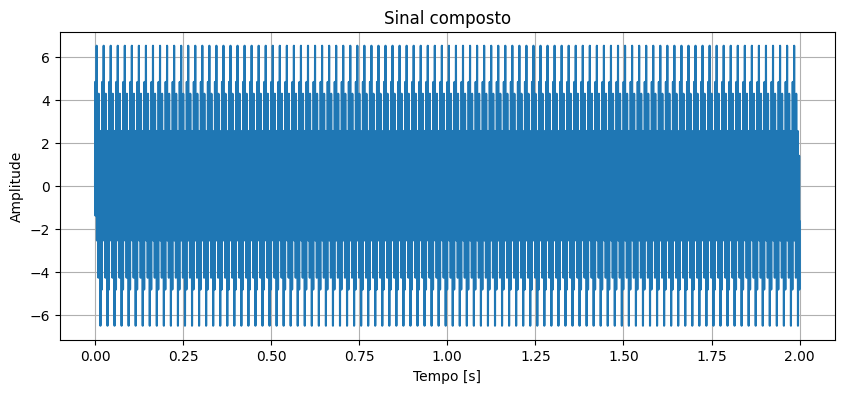

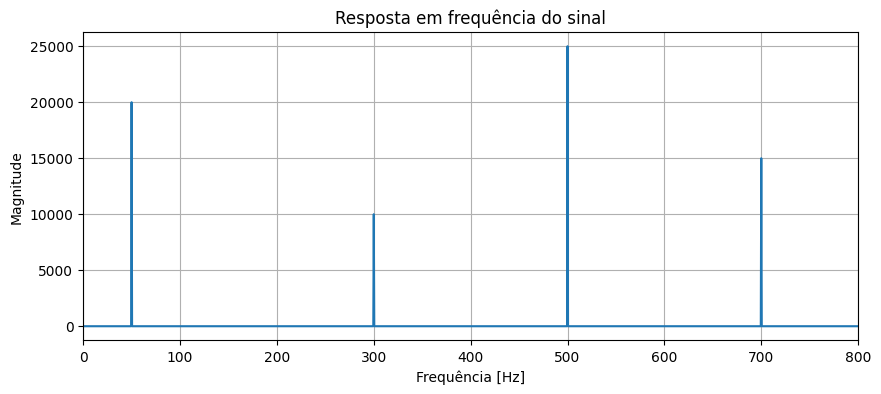

In [63]:
fs = 10000

components = {
    50: 2,   # 50Hz com amplitude 2
    300: 1,  # 300Hz com amplitude 1
    500: 2.5, # 500Hz com amplitude 2.5
    700: 1.5 # 700Hz com amplitude 1.5
}

signal_data, time = get_signal(components=components, frequency=fs)

plot_signal(signal=signal_data, time=time, frequency=fs)

### 2) Projetar um filtro IIR Elíptico para eliminar as componentes (reduzir para menos de 5% de sua amplitude original) 300Hz e 500Hz, usando funções de construção de filtros do Python (Scipy.signal). É desejável que o filtro não afete (tolerância de ±5%) as amplitudes das componentes que devem permanecer no sinal.


H(z): <TransferFunction>: sys[2]$sampled
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


0.6389 z^10 - 6.39 z^9 + 28.76 z^8 - 76.69 z^7 + 134.2 z^6 - 161.1 z^5 + 134.3 z^4 - 76.72 z^3 + 28.77 z^2 - 6.395 z + 0.6395
-----------------------------------------------------------------------------------------------------------------------------
      z^10 - 10 z^9 + 45.01 z^8 - 120 z^7 + 210.1 z^6 - 252.1 z^5 + 210.1 z^4 - 120.1 z^3 + 45.03 z^2 - 10.01 z + 1.001

dt = 0.0001



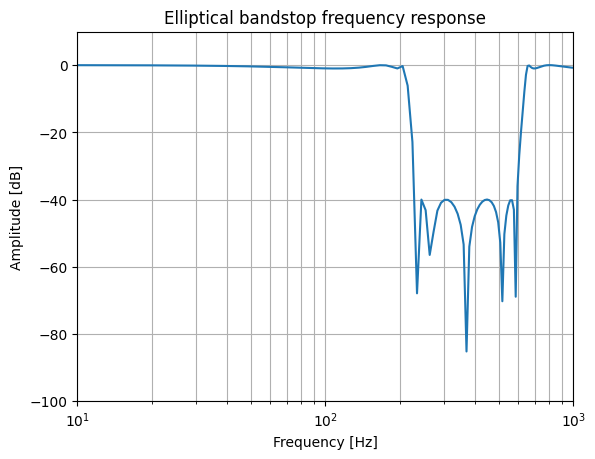

In [65]:
wp = [100, 650]
ws = [250, 550]
gpass = 1
gstop = 40


b, a = signal.iirdesign(wp, ws, gpass, gstop, fs=fs, output='ba', ftype='ellip')
w, h = signal.freqz(b, a, fs=fs)

Hs = ctl.tf(b, a)
ts = 1/fs
Hz = ctl.c2d(Hs, ts, 'bilinear')
print('H(z):', Hz)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.semilogx(w, 20 * np.log10(np.maximum(abs(h), 1e-5)))
ax.set_title('Elliptical bandstop frequency response')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude [dB]')
ax.axis((10, 1000, -100, 10))
ax.grid(which='both', axis='both')
plt.show()




### 3) Fazer uma função Python para implementar o filtro projetado. Esta função deve receber como argumento de entrada somente o sinal a ser filtrado e deve devolver somente o sinal filtrado e não deve conter comandos de construção do filtro. Aplicar esta função no sinal do exercício 1. Forneça o espectro do sinal filtrado e valores numéricos das amplitudes que comprovam o funcionamento da função de filtragem.

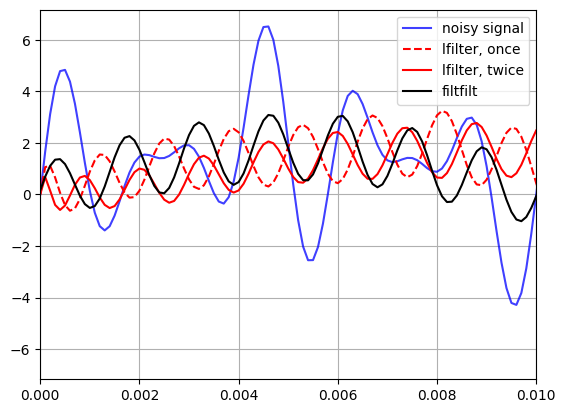

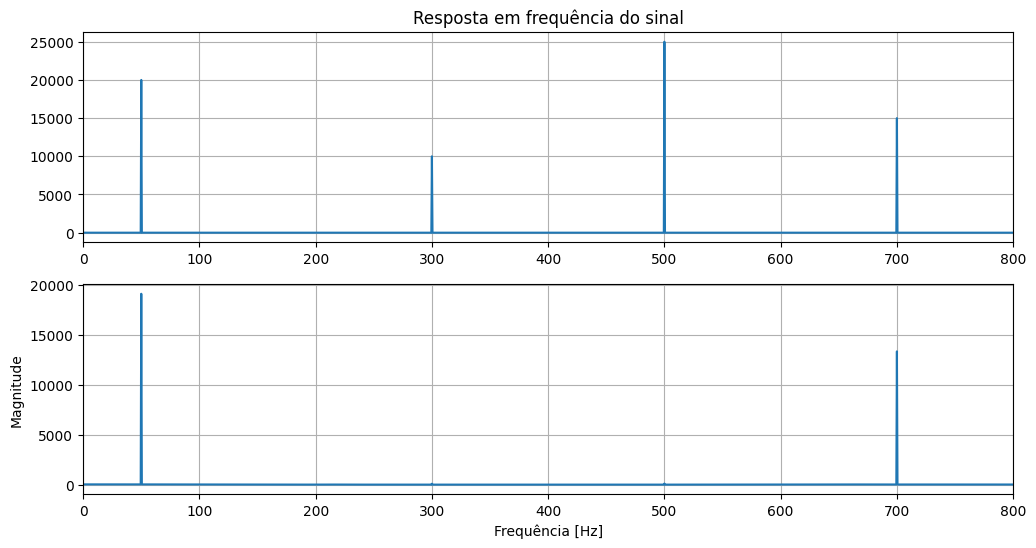

In [66]:
t = np.arange(0, 2, 1/fs)

zi = signal.lfilter_zi(b, a)
z, _ = signal.lfilter(b, a, signal_data, zi=zi*signal_data[0])

#aplicar o filtro uma segunda vez.
z2, _ = signal.lfilter(b, a, z, zi=zi*z[0])

# aplicar com filtfilt, para comparação.
y = signal.filtfilt(b, a, signal_data)


# plotar os sinais
plt.figure(1)
plt.plot(t, signal_data, 'b', alpha=0.75)
plt.plot(t, z, 'r--', t, z2, 'r', t, y, 'k')
plt.legend(('noisy signal', 'lfilter, once', 'lfilter, twice', 'filtfilt'), loc='best')
plt.grid(True)
plt.xlim(0, 0.01)
plt.show()


# Resposta em frequência (FFT)
frequencia = np.fft.fftfreq(len(signal_data), 1/fs)
espectro = np.fft.fft(signal_data)

frequencia_filtr = np.fft.fftfreq(len(z), 1/fs)
espectro_filtr = np.fft.fft(z)

# Plotar a magnitude da resposta em frequência
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(frequencia[:len(frequencia)//2], np.abs(espectro)[:len(frequencia)//2])
plt.title('Resposta em frequência do sinal')
plt.grid(True)
plt.xlim(0, 800)
plt.subplot(2, 1, 2)
plt.plot(frequencia_filtr[:len(frequencia_filtr)//2], np.abs(espectro_filtr)[:len(frequencia_filtr)//2])
plt.xlabel('Frequência [Hz]')
plt.ylabel('Magnitude')
plt.grid(True)
plt.xlim(0, 800)
plt.show()

### 4) O seguinte espectro é correspondente a um sinal de alarme de equipamentos médicos padronizado, (ISO-TC121-SC3_high.wav), o qual é composto por várias frequências. Pede-se:

a) Construir um programa em Python para ler o arquivo fornecido, obter suas características (taxa de
amostragem, numero de canais, profundidade de bits, etc). Plotar o sinal original e seu espectro.

C:\Users\felip\AppData\Local\Temp\ipykernel_21356\1893900482.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  taxa, audio_data = wavfile.read(audio_path)


Taxa de amostragem: 44100 Hz
Numero de cainais: 1
Profundidade de bits: int16


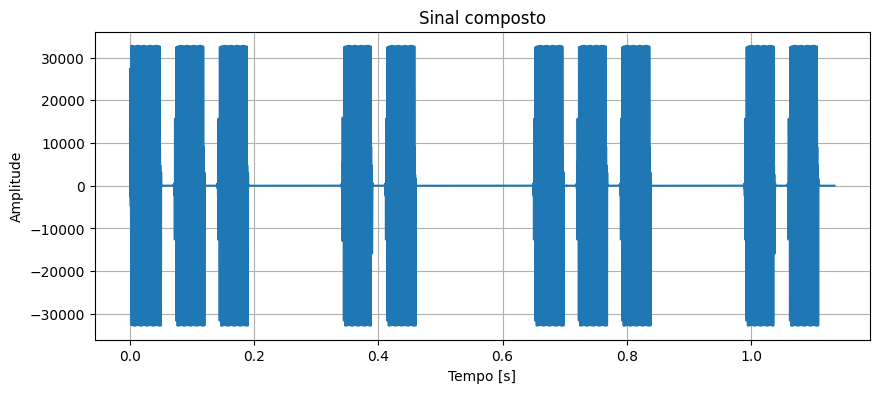

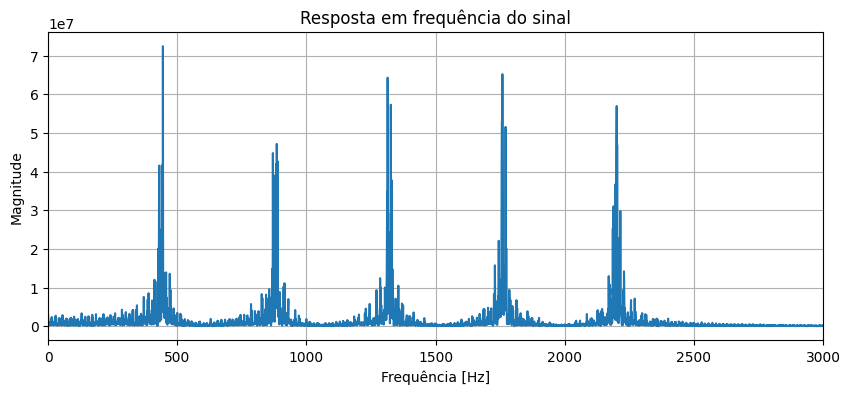

In [40]:
from pathlib import Path
import os
# Carregar o arquivo de áudio
audio_path = Path(os.getcwd()) / 'audios' / 'ISO-TC121-SC3_high.wav'

taxa, audio_data = wavfile.read(audio_path)

print(f'Taxa de amostragem: {taxa} Hz')
print(f'Numero de cainais: {audio_data.ndim}')
print(f'Profundidade de bits: {audio_data.dtype}')

plot_signal(signal=audio_data, time=np.arange(len(audio_data))/taxa, frequency=taxa, limite=3000)


b) A partir dos dados brutos de um dos canais, tocar o som correspondente

c) Projetar um filtro IIR Elíptico para eliminar as componentes (reduzir para menos de 5% de sua
amplitude original) de 800Hz a 1700Hz, usando funções de construção de filtros do Python
(Scipy.signal). É desejável que o filtro não afete (tolerância de ±5%) as amplitudes das componentes
que devem permanecer no sinal. Para o filtro projetado apresentar os mesmos itens solicitados na
questão 2.

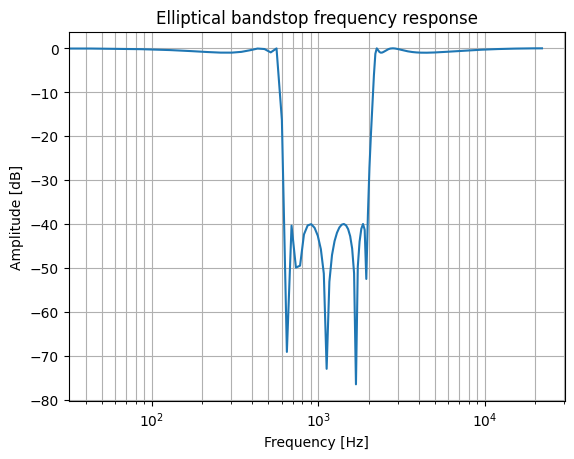

In [55]:
wp = [500, 2200]
ws = [700, 1800]
gpass = 1
gstop = 40


b, a = signal.iirdesign(wp, ws, gpass, gstop, fs=taxa, output='ba', ftype='ellip')
w, h = signal.freqz(b, a, fs=taxa)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.semilogx(w, 20 * np.log10(np.maximum(abs(h), 1e-5)))
ax.set_title('Elliptical bandstop frequency response')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude [dB]')
# ax.axis((10, 1000, -100, 10))
ax.grid(which='both', axis='both')
plt.show()

d) Aplicar o filtro projetado no sinal de áudio, utilizando funções da biblioteca do Python. Apresentar
o espectro do sinal filtrado. 

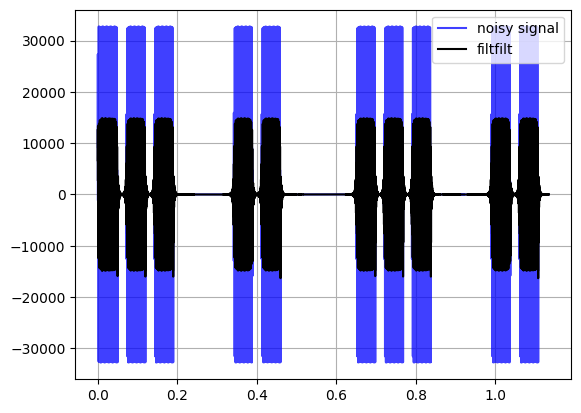

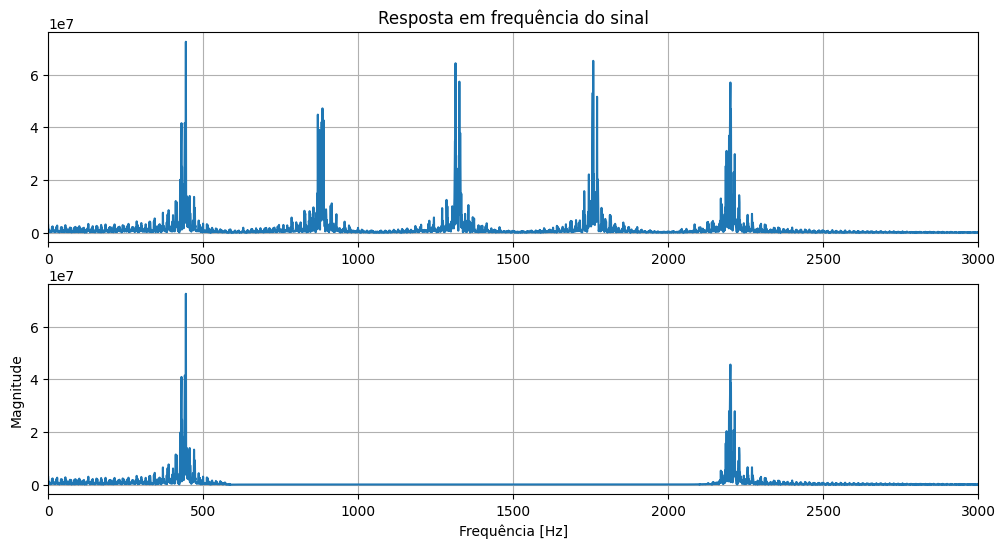

In [58]:
t = np.arange(len(audio_data))/taxa

# zi = signal.lfilter_zi(b, a)
# z, _ = signal.lfilter(b, a, audio_data, zi=zi*audio_data[0])

# #aplicar o filtro uma segunda vez.
# z2, _ = signal.lfilter(b, a, z, zi=zi*z[0])

# aplicar com filtfilt, para comparação.
y = signal.filtfilt(b, a, audio_data)


# plotar os sinais
plt.figure(1)
plt.plot(t, audio_data, 'b', alpha=0.75)
plt.plot(t, y, 'k')
plt.legend(('noisy signal', 'filtfilt'), loc='best')
plt.grid(True)
# plt.xlim(0, 0.004)
plt.show()


# Resposta em frequência (FFT)
frequencia = np.fft.fftfreq(len(audio_data), 1/taxa)
espectro = np.fft.fft(audio_data)

frequencia_filtr = np.fft.fftfreq(len(y), 1/taxa)
espectro_filtr = np.fft.fft(y)

# Plotar a magnitude da resposta em frequência
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(frequencia[:len(frequencia)//2], np.abs(espectro)[:len(frequencia)//2])
plt.title('Resposta em frequência do sinal')
plt.grid(True)
plt.xlim(0, 3000)
plt.subplot(2, 1, 2)
plt.plot(frequencia_filtr[:len(frequencia_filtr)//2], np.abs(espectro_filtr)[:len(frequencia_filtr)//2])
plt.xlabel('Frequência [Hz]')
plt.ylabel('Magnitude')
plt.grid(True)
plt.xlim(0, 3000)
plt.show()

e) Tocar o som correspondente ao sinal filtrado. Plotar os gráficos do sinal